In [1]:
!pip install -q catboost

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings

#settings
warnings.filterwarnings("ignore")


In [3]:
appearances_df = pd.read_csv("../raw_data/appearances.csv")
clubs_df = pd.read_csv("../raw_data/clubs.csv")
games_df = pd.read_csv("../raw_data/games.csv")
players_df = pd.read_csv("../raw_data/players.csv")

#add year to game valuations

players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 

# Calculate the contract remaining of each player
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 

# add year to player appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year
appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
    
games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
games_df['year']=games_df['datetime'].dt.year
games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')


features=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022',
          'age','height_in_cm','squad_size','term_days_remaining','position_Attack','position_Defender',
          'position_Goalkeeper','position_Midfield','sub_position_Attacking Midfield','sub_position_Central Midfield',
          'sub_position_Centre-Back','sub_position_Centre-Forward','sub_position_Defensive Midfield',
          'sub_position_Left Midfield','sub_position_Left Winger','sub_position_Left-Back','sub_position_Right Midfield',
          'sub_position_Right Winger','sub_position_Right-Back','sub_position_Second Striker','foot_Left','foot_Right','foot_Both']


In [4]:
#create a function to collate player stats
def player_stats(player_id, season, games_and_appearances_df):
      
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for',
                                                     'goals_against','clean_sheet',
                                                     'yellow_cards','red_cards'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                    'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                    'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df


In [5]:
def preprocessing(appearances_df,clubs_df,games_df,players_df,games_and_appearances_df):
    
    #Start with players_df
    merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)
    #next look at clubs_df
    merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2022','games_2022','assists_2022','minutes_played_2022','goals_against_2022','goals_for_2022','clean_sheet_2022'])
    
    for player_id in merged_players_df.player_id.unique():
        club_id = players_df.current_club_id[(players_df.player_id==player_id)]
        try:
            merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
        except:
            merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
        merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

    columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022','clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
    merged_players_df=merged_players_df[columns]
    
    season = 2022 

    #iterate through players
    for index in merged_players_df.index:
        id = merged_players_df.loc[index][0]
        #print(id)
        name = merged_players_df.loc[index][1]
        stats = player_stats(id, season, games_and_appearances_df)
        try:
            merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
            merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
            merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
            merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
            merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
            merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
            merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
            merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
            merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
        except:
            n=n+1 

    #drop nan
    merged_players_df=merged_players_df.dropna(subset=['market_value_in_eur'])
    merged_players_df1 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='GB1')]
    # convert position categories to Columns for test data
    dummies=pd.get_dummies(merged_players_df1[['position']], prefix_sep='_') #position
    merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
    
    # convert position categories to Columns for test data
    dummies=pd.get_dummies(merged_players_df1[['sub_position']], prefix_sep='_') 
    merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
    dummies=pd.get_dummies(merged_players_df1[['foot']], prefix_sep='_') #foot
    merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 

    #separate numeric columns
    merged_players_df2 = merged_players_df1[features]
    merged_players_df2['market_value_in_eur'] = merged_players_df1['market_value_in_eur']
    
    return merged_players_df2
    

In [6]:
merged_players_df2=preprocessing(appearances_df,clubs_df,games_df,players_df,games_and_appearances_df)

0:	learn: 10550223.2172234	total: 52.3ms	remaining: 471ms
1:	learn: 10252883.6010770	total: 52.8ms	remaining: 211ms
2:	learn: 8822188.2340264	total: 53ms	remaining: 124ms
3:	learn: 8456513.2868812	total: 53.2ms	remaining: 79.8ms
4:	learn: 8196178.9213635	total: 53.4ms	remaining: 53.4ms
5:	learn: 8094984.1819270	total: 53.6ms	remaining: 35.7ms
6:	learn: 7525579.7111649	total: 53.8ms	remaining: 23.1ms
7:	learn: 7369551.4324284	total: 54ms	remaining: 13.5ms
8:	learn: 7154969.0727233	total: 54.2ms	remaining: 6.02ms
9:	learn: 7077501.1055683	total: 54.4ms	remaining: 0us


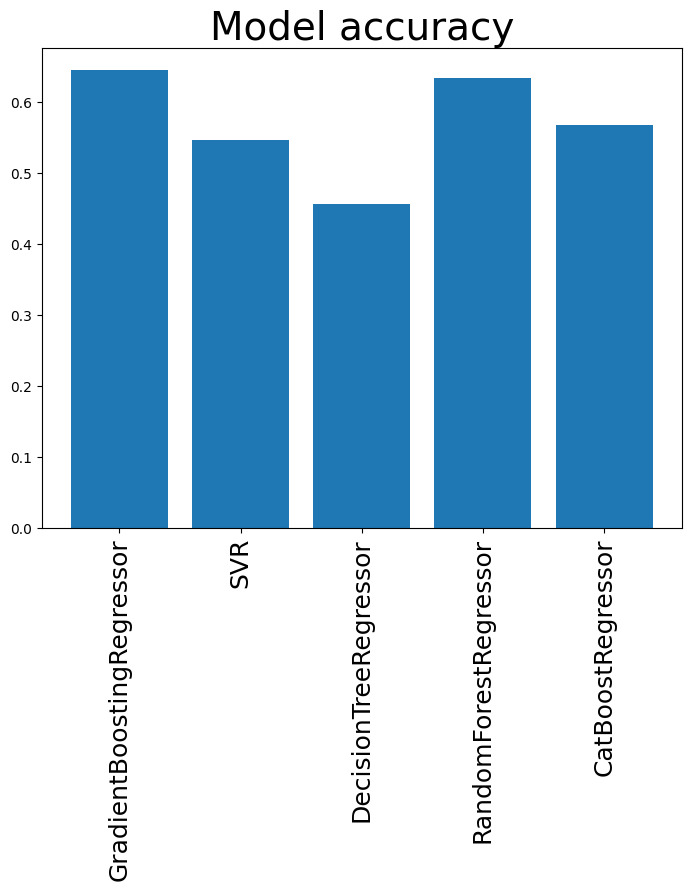

                       model  accuracy
0  GradientBoostingRegressor  0.643825
1                        SVR  0.546155
2      DecisionTreeRegressor  0.455569
3  GradientBoostingRegressor  0.621906
4      RandomForestRegressor  0.632682
5          CatBoostRegressor  0.566437


In [7]:
# check model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline


X = merged_players_df2[features].fillna(-1000)
y=merged_players_df2['market_value_in_eur']
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
comparisons_df = pd.DataFrame(columns=['model','accuracy'])
#model data
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
XGBR = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.04, random_state=1)
cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
#lgbm=LGBMRegressor()

models=[gbr,svr,dtr,XGBR,rfr,cat]
for model in models:
    model.fit(X_train, y_train)
    #assess accurancy of model
    comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__,model.score(X_test, y_test)]
#create barchart to show performances
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = comparisons_df.model
y = comparisons_df.accuracy
ax.bar(x,y)
plt.xticks(fontsize=18, rotation=90)
plt.title('Model accuracy',fontsize=28)
plt.show()
print(comparisons_df)